In [1]:
import datetime
import gc
import math
import os

import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm.notebook import tqdm

In [2]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 20)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
pd.set_option('precision', 6)    # n是要显示的精度，应该是一个整数


In [3]:
sns.set(style='darkgrid')
train_path = '../../input/hy_round1_train_20200102'
test_path = '../../input/hy_round1_testA_20200102'

train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(f"训练样本：{len(train_files)}")
print(f"测试样本：{len(test_files)}")

训练样本：7000
测试样本：2000


In [4]:
df_4924 = pd.read_csv(f'{train_path}/4924.csv')
print(f"作业类型：{df_4924['type'].unique()}")
print(f"数据维度：{df_4924.shape}")

作业类型：['围网']
数据维度：(3969, 7)


In [5]:
def df_angle_handle(dataframe):
    """方向编码"""
    if '方向' in dataframe.columns:
        sin_list = []
        cos_list = []
        for angle in dataframe['方向'].values:
            sin_list.append(math.sin(math.radians(angle)))
            cos_list.append(math.cos(math.radians(angle)))
        dataframe['sin_angle'] = sin_list
        dataframe['cos_angle'] = cos_list
        # dataframe = dataframe.drop('方向', axis=1)
    else:
        print("没有方向列或已经处理完毕")
    return dataframe

In [6]:
df_4924 = df_angle_handle(df_4924)

In [7]:
df_4924

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle
0,4924,6.328956e+06,5.291393e+06,0.38,103,1113 23:59:30,围网,0.974370,-0.224951
1,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:58:27,围网,0.000000,1.000000
2,4924,6.328956e+06,5.291393e+06,0.00,0,1113 23:57:24,围网,0.000000,1.000000
3,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:56:20,围网,0.000000,1.000000
4,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:55:17,围网,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
3964,4924,6.342718e+06,5.283126e+06,9.17,132,1111 00:04:36,围网,0.743145,-0.669131
3965,4924,6.342517e+06,5.283346e+06,8.96,149,1111 00:03:33,围网,0.515038,-0.857167
3966,4924,6.342316e+06,5.283566e+06,8.85,137,1111 00:02:30,围网,0.681998,-0.731354
3967,4924,6.342115e+06,5.283786e+06,9.07,146,1111 00:01:27,围网,0.559193,-0.829038


In [8]:
def show_one_path(df, figsize=(50, 50), fontsize=50):
    plt.figure(figsize=figsize)
    plt.plot(df['x'], df['y'])
    X = df['x'].values.flatten()
    Y = df['y'].values.flatten()
    U = df['sin_angle'].values.flatten()
    V = df['cos_angle'].values.flatten()
    plt.quiver(X, Y, U, V, angles="xy",color="#666666")
    
    cur_id = df['渔船ID'].iloc[0] 
    # 中文标题，必要时可以不用
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.title(f'渔船ID：{cur_id}', size=fontsize)
    return 0

0

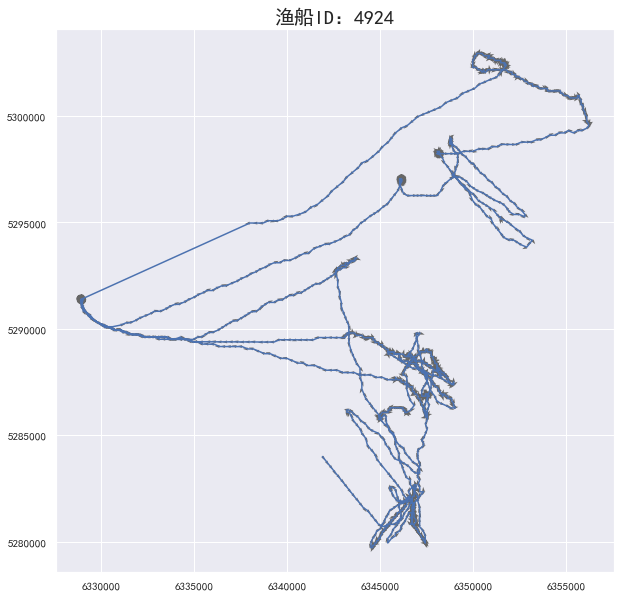

In [9]:
# 绘制全局
show_one_path(df_4924, figsize=(10, 10), fontsize=20)

In [10]:
def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    
    time_past_sec = []
    time_step_sec = []
    start = df['time'].iloc[-1]
    for i in range(len(df)):
        now_index = len(df) -1 - i
        time_past_sec.append((df['time'].iloc[now_index] - start).seconds)
        time_step_sec.append((df['time'].iloc[now_index - 1] - df['time'].iloc[now_index]).seconds)
    
    time_past_sec = time_past_sec[::-1]
    
    time_step_sec = time_step_sec[::-1]  # 时间步长是反转储存的
    time_step_sec.pop(0)
    time_step_sec.append(0)
    
    df['time_past_sec'] = pd.Series(time_past_sec)  # 经过的总时间
    df['time_step_sec'] = pd.Series(time_step_sec)  # 和上一次报告经过的时间
    
    return df

In [11]:
def extract_distance(df):
    """抽取距离、速度信息"""
    df['x_past'] = df['x'] - df['x'].iloc[-1]  # 和起始点比较？
    df['y_past'] = df['y'] - df['y'].iloc[-1]  # 还是和边界点比较？
    
    x_step = []
    y_step = []
    start = df['time'].iloc[-1]
    for i in range(len(df)):
        now_index = len(df) -1 - i
        x_step.append(np.abs(df['x'].iloc[now_index - 1] - df['x'].iloc[now_index]))
        y_step.append(np.abs(df['y'].iloc[now_index - 1] - df['y'].iloc[now_index]))
    
    x_step = x_step[::-1]  # 时间步长是反转储存的
    x_step.pop(0)
    x_step.append(0)
    y_step = y_step[::-1]  # 时间步长是反转储存的
    y_step.pop(0)
    y_step.append(0)
    
    df['x_step'] = pd.Series(x_step)  # 每次报告的x轴距离
    df['y_step'] = pd.Series(y_step)  # 每次报告的y轴距离
    
    df['xy_distance_step'] = np.sqrt(df['x_step']**2 + df['y_step']**2)
    df['xy_velocity_step'] = df['xy_distance_step']/(df['time_step_sec'] + 1)  # +1避免除以0
    return df

In [12]:
df_4924_time = extract_dt(df_4924.copy())

In [13]:
df_4924_time = extract_distance(df_4924_time)

In [14]:
df_4924_time.iloc[2120:2125]

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step
2120,4924,6.347658e+06,5.288264e+06,4.16,277,1900-11-12 09:03:27,围网,-0.992546,0.121869,11,12,9,3,27,32584,127,5743.437054,4258.294822,100.598911,0.233139,100.599181,0.785931
2121,4924,6.347759e+06,5.288263e+06,2.05,295,1900-11-12 09:01:20,围网,-0.906308,0.422618,11,12,9,1,20,32457,63,5844.035964,4258.061683,0.190981,109.576873,109.577039,1.712141
2122,4924,6.347758e+06,5.288154e+06,3.08,290,1900-11-12 09:00:17,围网,-0.939693,0.342020,11,12,9,0,17,32394,63,5843.844983,4148.484810,100.599745,0.232134,100.600013,1.571875
2123,4924,6.347859e+06,5.288153e+06,2.16,303,1900-11-12 08:59:14,围网,-0.838671,0.544639,11,12,8,59,14,32331,63,5944.444728,4148.252676,0.000000,0.000000,0.000000,0.000000
2124,4924,6.347859e+06,5.288153e+06,2.00,313,1900-11-12 08:58:11,围网,-0.731354,0.681998,11,12,8,58,11,32268,127,5944.444728,4148.252676,100.410431,109.807674,148.795094,1.162462


0

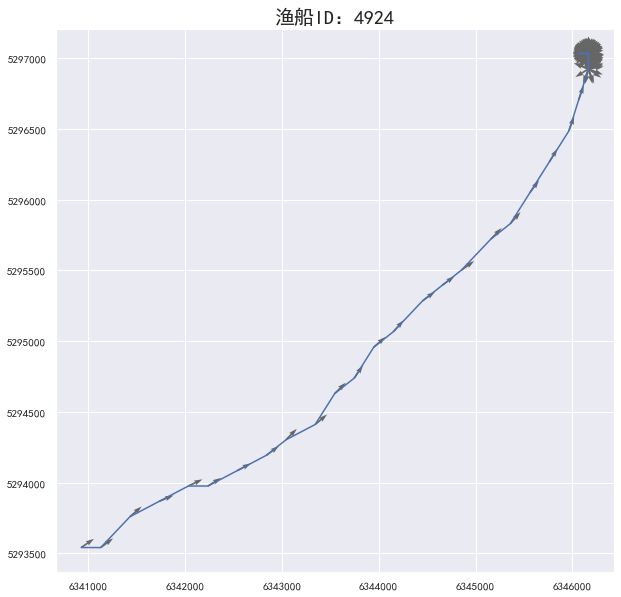

In [15]:
show_one_path(df_4924_time.iloc[1500:1900], figsize=(10, 10), fontsize=20)

In [16]:
df_4924_time['time_step_sec'].value_counts()

63      2884
64       984
127       34
126       26
62        25
65        10
61         2
189        1
4238       1
136        1
0          1
Name: time_step_sec, dtype: int64

In [17]:
df_4924_time[df_4924_time['time_step_sec'] > 2800]

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step
655,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 12:23:45,围网,0.0,1.0,11,13,12,23,45,44602,4238,-12958.122357,7387.444822,9060.66233,3582.718259,9743.278297,2.298485


In [18]:
df_4924_time.iloc[650:660]

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step
650,4924,6.328956e+06,5.291393e+06,0.00,0,1900-11-13 12:29:01,围网,0.000000,1.000000,11,13,12,29,1,44918,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
651,4924,6.328956e+06,5.291393e+06,0.16,288,1900-11-13 12:27:58,围网,-0.951057,0.309017,11,13,12,27,58,44855,64,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
652,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 12:26:54,围网,0.000000,1.000000,11,13,12,26,54,44791,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
653,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 12:25:51,围网,0.000000,1.000000,11,13,12,25,51,44728,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
654,4924,6.328956e+06,5.291393e+06,0.00,0,1900-11-13 12:24:48,围网,0.000000,1.000000,11,13,12,24,48,44665,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
655,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 12:23:45,围网,0.000000,1.000000,11,13,12,23,45,44602,4238,-12958.122357,7387.444822,9060.662330,3582.718259,9743.278297,2.298485
656,4924,6.338017e+06,5.294975e+06,9.55,260,1900-11-13 11:13:07,围网,-0.984808,-0.173648,11,13,11,13,7,40364,63,-3897.460027,10970.163081,402.190457,1.312571,402.192599,6.284259
657,4924,6.338419e+06,5.294974e+06,9.44,266,1900-11-13 11:12:04,围网,-0.997564,-0.069756,11,13,11,12,4,40301,64,-3495.269571,10968.850511,301.642947,0.973859,301.644519,4.640685
658,4924,6.338721e+06,5.294973e+06,9.55,263,1900-11-13 11:11:00,围网,-0.992546,-0.121869,11,13,11,11,0,40237,63,-3193.626624,10967.876652,301.906548,108.632260,320.855936,5.013374
659,4924,6.339023e+06,5.295082e+06,9.07,264,1900-11-13 11:09:57,围网,-0.994522,-0.104528,11,13,11,9,57,40174,63,-2891.720076,11076.508912,301.640637,0.955733,301.642151,4.713159


0

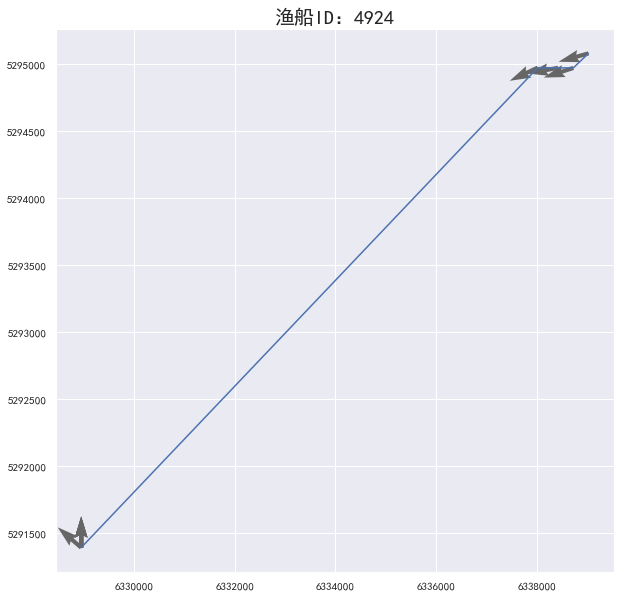

In [19]:
show_one_path(df_4924_time.iloc[650:660], figsize=(10, 10), fontsize=20)

In [20]:
def sep_long_data(df):
    """简单粗暴对半开"""
    if len(df)>1000:
        df1 = df.iloc[:len(df)//2]
        df2 = df.iloc[len(df)//2:]
        return df1, df2
    else:
        return df

In [21]:
len(df_4924_time) 

3969

In [22]:
if len(df_4924_time)>1000:
    df1, df2 = sep_long_data(df_4924_time)

0

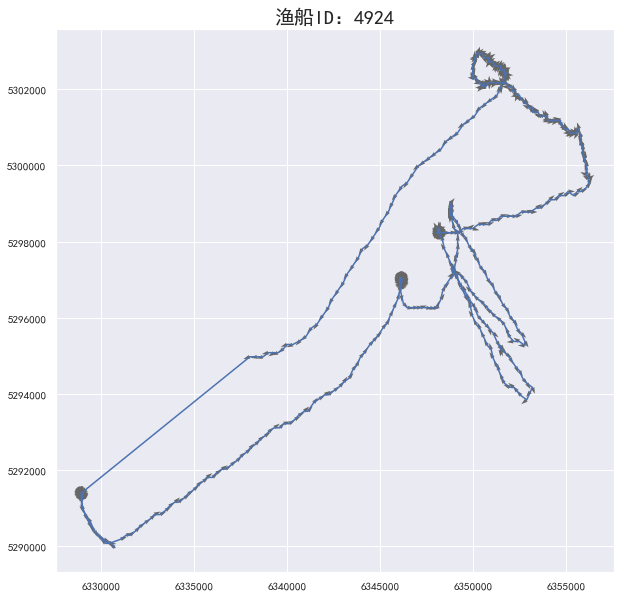

In [23]:
show_one_path(df1, figsize=(10, 10), fontsize=20)

0

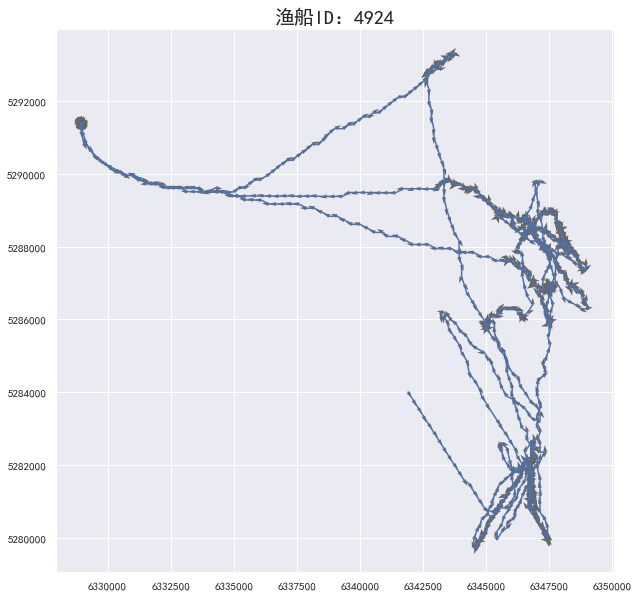

In [24]:
show_one_path(df2, figsize=(10, 10), fontsize=20)

In [25]:
14000 * 4 + 15900 * 8 + 59000

242200